In [7]:
import torch 
import os 

%cd /workspace/Walk_Video_PyTorch/project

/workspace/Walk_Video_PyTorch/project


In [2]:
from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule

from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()

import torchmetrics

In [3]:
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

Global seed set to 42


42

In [4]:
# define the metrics.
_accuracy = torchmetrics.classification.BinaryAccuracy()
_precision = torchmetrics.classification.BinaryPrecision()
_binary_recall = torchmetrics.classification.BinaryRecall()
_binary_f1 = torchmetrics.classification.BinaryF1Score()

_confusion_matrix = torchmetrics.classification.BinaryConfusionMatrix()

_aucroc = torchmetrics.classification.BinaryAUROC()

In [10]:
from parameters import get_parameters

VIDEO_LENGTH = ['1', '2', '3']
VIDEO_FRAME = ['8', '16', '32']

opt, _ = get_parameters()
opt.num_workers = 8
opt.batch_size = 8
opt.gpu_num = 1

opt.version = '1201_1_16'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

opt.clip_duration = 2
opt.uniform_temporal_subsample_num = 30
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)

opt.fusion_method = 'slow_fusion'
opt.fix_layer = 'all'
opt.train_path = '/workspace/data/split_pad_dataset_512/fold3/'

opt.transfor_learning = True
opt.pre_process_flag = True

DATA_PATH = opt.split_pad_data_path

In [6]:
def get_best_ckpt(length: str, frame: str, fold: str):

    ckpt_path = '/workspace/Walk_Video_PyTorch/logs/resnet/'
    ckpt_path_list = os.listdir(ckpt_path)
    ckpt_path_list.sort()

    final_ckpt_list = [] 

    for i in ckpt_path_list:
        if len(i) < 25:
            final_ckpt_list.append(i)

    final_ckpt_list.sort()
    
    for name in final_ckpt_list:
        if length in name.split('_') and frame in name.split('_'):
            ckpt = name

    ckpt = os.path.join(ckpt_path, ckpt, fold, 'checkpoints')
    
    Acc = 0.0

    ckpt_list = os.listdir(ckpt)
    ckpt_list.sort()
    ckpt_list.remove('last.ckpt')

    for num, l in enumerate(ckpt_list):
        acc = l[-11:-5] # accuracy

        if float(acc) > float(Acc):
            Acc = acc
            NUM = num

    return os.path.join(ckpt, ckpt_list[NUM])


In [11]:
def get_inference(test_data, model):
        
    pred_list = []
    label_list = []

    for i, batch in enumerate(test_data):

        # input and label
        video = batch['video'].detach().cuda() # b, c, t, h, w

        label = batch['label'].detach().cuda() # b, class_num

        model.cuda().eval()

        # pred the video frames
        with torch.no_grad():
            preds = model(video)

        # when torch.size([1]), not squeeze.
        if preds.size()[0] != 1 or len(preds.size()) != 1 :
            preds = preds.squeeze(dim=-1)
            preds_sigmoid = torch.sigmoid(preds)
        else:
            preds_sigmoid = torch.sigmoid(preds)

        pred_list.append(preds_sigmoid.tolist())
        label_list.append(label.tolist())

        total_pred_list = []
        total_label_list = []

        for i in pred_list:
            for number in i:
                total_pred_list.append(number)

        for i in label_list:
            for number in i: 
                total_label_list.append(number)

    pred = torch.tensor(total_pred_list)
    label = torch.tensor(total_label_list)

    return total_pred_list, total_label_list

In [12]:
VIDEO_LENGTH = ['1']
VIDEO_FRAME = ['8']

In [13]:
fold_num = os.listdir(DATA_PATH)
fold_num.sort()
fold_num.remove('raw')

symbol = '_'

one_condition_pred_list = []
one_condition_label_list = []

total_pred_list = []
total_label_list = []

for length in VIDEO_LENGTH:

    for frame in VIDEO_FRAME:

        for fold in fold_num:

            opt.train_path = os.path.join(DATA_PATH, fold)

            #################
            # start k Fold CV
            #################
            
            opt.clip_duration = int(length)
            opt.uniform_temporal_subsample_num = int(frame)
           
            ckpt_path = get_best_ckpt(length, frame, fold)

            print('#' * 50)
            print('Strat %s, %s length, %s frames' % (fold, length, frame))
            print('the data path: %s' % opt.train_path)
            print('ckpt: %s' % ckpt_path)
            model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

            data_module = WalkDataModule(opt)
            data_module.setup()
            test_data = data_module.test_dataloader()

            pred_list, label_list = get_inference(test_data, model)

            one_condition_pred_list.append(pred_list)

            one_condition_label_list.append(label_list)

        # total 5 fold pred and label
        for i in one_condition_pred_list:
            for number in i:
                total_pred_list.append(number)

        for i in one_condition_label_list:
            for number in i: 
                total_label_list.append(number)

        pred = torch.tensor(total_pred_list)    
        label = torch.tensor(total_label_list)

        print('*' * 100)
        print('the result of %ss %sframe:' % (length, frame))
        print('accuracy: %s' % _accuracy(pred, label))
        print('precision: %s' % _precision(pred, label))
        print('_binary_recall: %s' % _binary_recall(pred, label))
        print('_binary_f1: %s' % _binary_f1(pred, label))
        print('_aurroc: %s' % _aucroc(pred, label))
        print('_confusion_matrix: %s' % _confusion_matrix(pred, label))
        print('#' * 50)


##################################################
Strat flod0, 1 length, 8 frames
the data path: /workspace/data/split_pad_dataset_512/flod0
ckpt: /workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod0/checkpoints/epoch=12-val_loss=1.88-val_acc=0.7074.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/flod0
##################################################
##################################################
Strat flod1, 1 length, 8 frames
the data path: /workspace/data/split_pad_dataset_512/flod1
ckpt: /workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod1/checkpoints/epoch=1-val_loss=0.67-val_acc=0.6496.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/flod1
##################################################
##################################################
Strat flod2, 1 length, 8 frames
the data path: /workspace/data/split_pad_dataset_512/flod2
ckpt: /workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/flod2
##################################################
##################################################
Strat flod3, 1 length, 8 frames
the data path: /workspace/data/split_pad_dataset_512/flod3
ckpt: /workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod3/checkpoints/epoch=23-val_loss=0.47-val_acc=0.8568.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/flod3
##################################################
##################################################
Strat flod4, 1 length, 8 frames
the data path: /workspace/data/split_pad_dataset_512/flod4
ckpt: /workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod4/checkpoints/epoch=7-val_loss=2.38-val_acc=0.7263.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/flod4
##################################################
****************************************************************************************************
the result of 1s 8frame:
accuracy: tensor(0.7736)
precision: tensor(0.8622)
_binary_recall: tensor(0.6114)
_binary_f1: tensor(0.7155)
_aurroc: tensor(0.7786)
_confusion_matrix: tensor([[957,  89],
        [354, 557]])
##################################################


In [16]:
import numpy as np 

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
)

from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms


from captum.attr import visualization as viz

torch.manual_seed(123)
np.random.seed(123)

In [17]:
batch = next(iter(test_data))

video = batch['video'].detach() # b, c, t, h, w
label = batch['label'].detach() # b, class num

video.shape, label.shape

(torch.Size([8, 3, 8, 224, 224]), torch.Size([8]))

In [19]:
# preds the video
with torch.no_grad():
    preds = model(video.cuda())

In [22]:
_confusion_matrix(torch.sigmoid(preds.cpu()).squeeze(), label)

tensor([[4, 0],
        [4, 0]])

# Integrated Gradients 

In [23]:
# a series frame show 
def series_attr_show(attributions, raw_img, flag):
    '''
    show a series img where combine the raw img with the attr map.

    Args:
        attributions (tensor): attributions map, shape(b, c, f, h, w)
        raw_img (tensor): raw image, shape(b, c, f, h, w)
        flag (str): disease flag, choice [asd, asd_not]
    '''
    
    flag = flag.item()

    # to cpu and numpy
    attributions_ig = attributions.squeeze().cpu().detach().numpy() # c, f, h, w
    raw_img = raw_img.squeeze().cpu().detach().numpy() # c, f, h, w

    attr_ig_transpose = attributions_ig.transpose(1, 0, 2, 3) # f, c, h, w
    raw_img_transpose = raw_img.transpose(1, 0, 2, 3) # f, c, h, w

    f, c, h, w = attr_ig_transpose.shape

    for frame in range(f):

        now_attr_ig = attr_ig_transpose[frame].transpose(1, 2, 0) # h, w, c
        now_raw_img = raw_img_transpose[frame].transpose(1, 2, 0) # h, w, c

        # the attr map and raw img must have shape (h, w, c)
        figure, axis = viz.visualize_image_attr_multiple(now_attr_ig, 
                                now_raw_img,
                                methods=['original_image', 'blended_heat_map'],
                                signs=['all', 'positive'],
                                show_colorbar=True,
                                outlier_perc=1, 
                                titles=['%s frame' % frame, 'attributions ig, label %s' % flag])


In [24]:
label

tensor([0, 0, 1, 0, 1, 1, 0, 1])

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


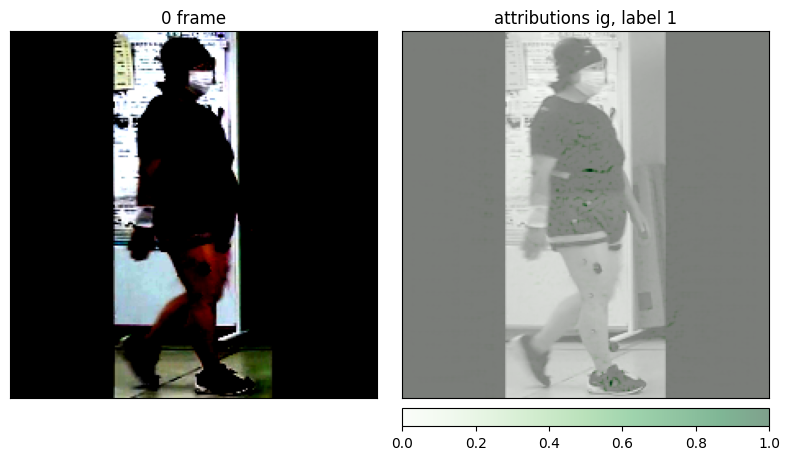

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


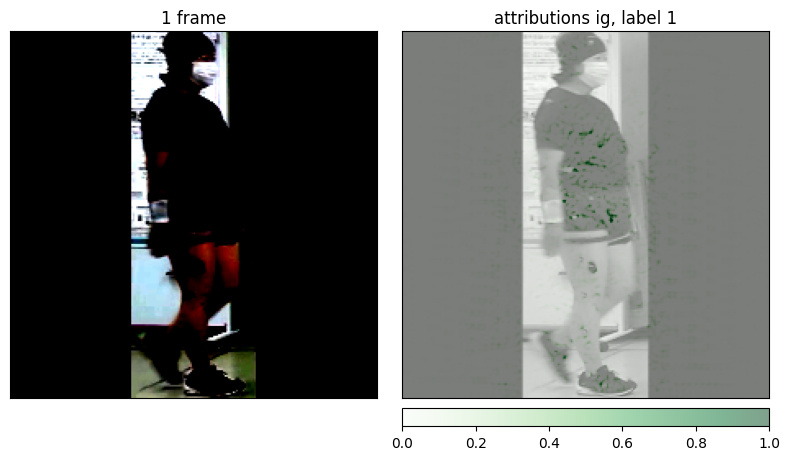

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


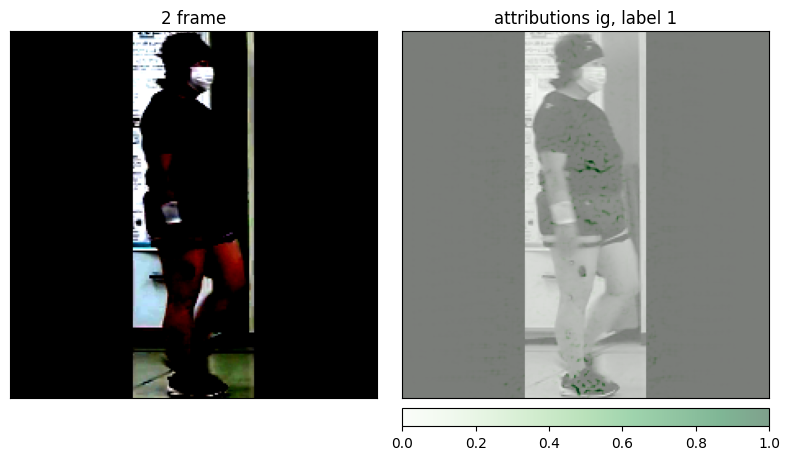

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


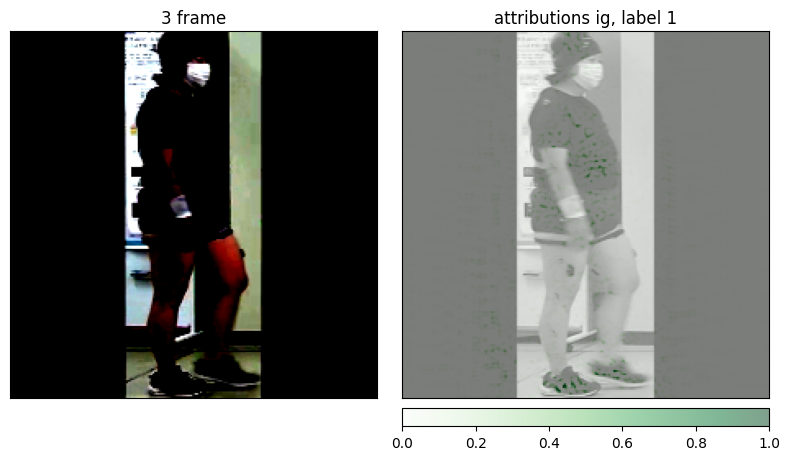

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


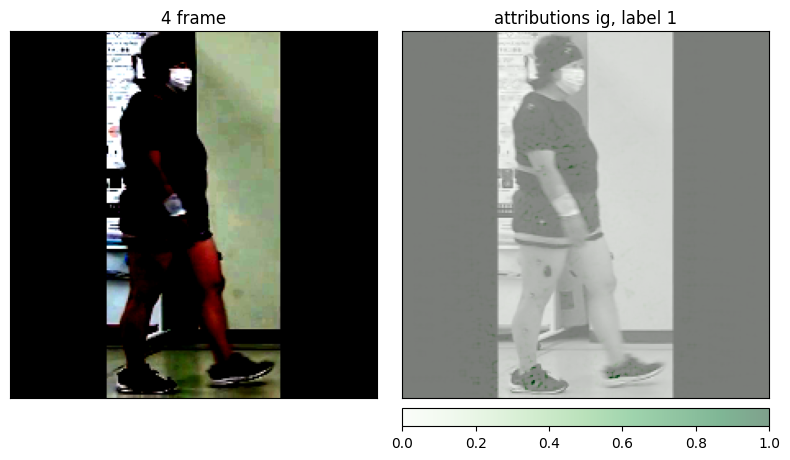

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


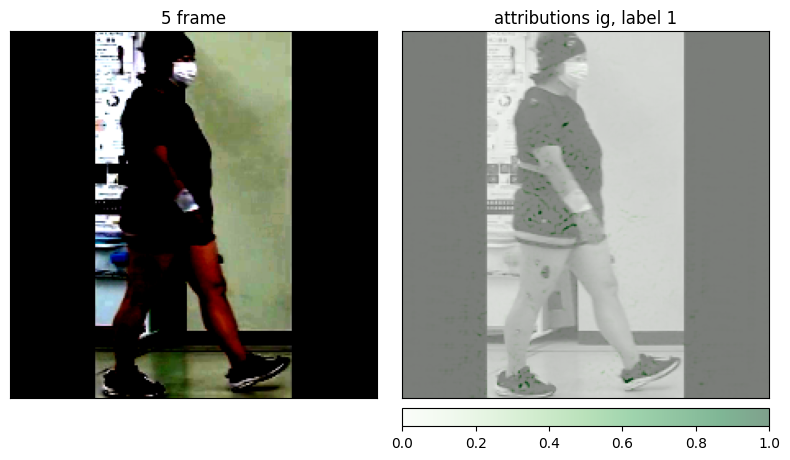

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


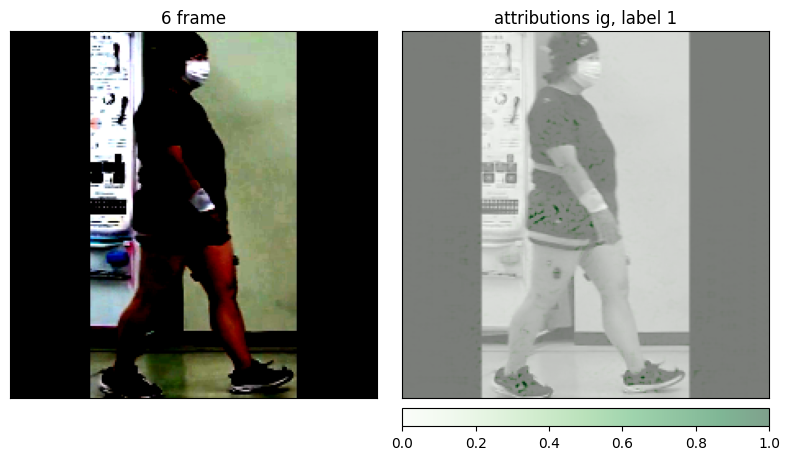

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


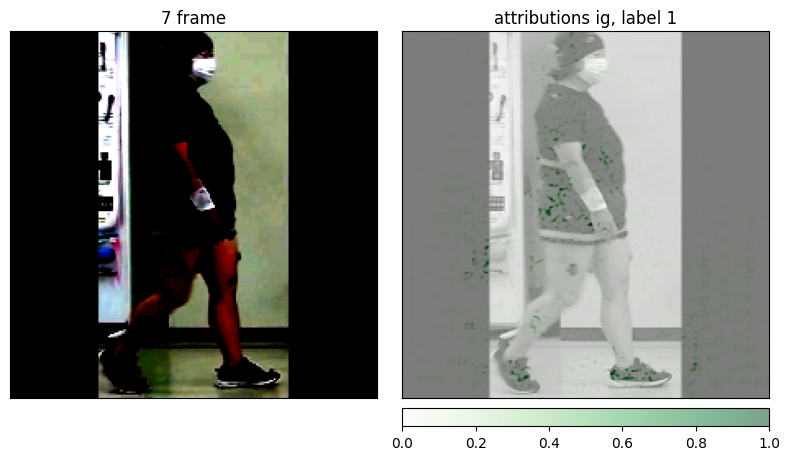

In [27]:
# define the gradient model
ig = IntegratedGradients(model.cuda())

input = video[2].unsqueeze(dim=0).cuda()

attributions_ig, delta = ig.attribute(input, target=0, return_convergence_delta=True, internal_batch_size=1)
attributions_ig.shape, delta

# show a series attr with raw img
series_attr_show(attributions_ig, input, flag=label[2])

In [31]:
attributions_ig.shape


torch.Size([1, 3, 8, 224, 224])

In [ ]:
# # default_cmap = LinearSegmentedColormap.from_list('custom blue', 
# #                                                  [(0, '#ffffff'),
# #                                                   (0.25, '#000000'),
# #                                                   (1, '#000000')], N=256)

# _ = viz.visualize_image_attr(attributions_ig_asd_not, 
#                              raw_img,
#                              method='blended_heat_map',
#                             #  cmap=default_cmap,
#                              show_colorbar=True,
#                              sign='all',
#                              outlier_perc=1, 
#                              title='attributions ig asd not ')

In [ ]:
# guided grad cam method
target_layer = model.model.blocks[-2].res_blocks[0].branch1_conv

In [ ]:
target_layer

Conv3d(1024, 2048, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)

/opt/conda/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/opt/conda/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/conda/lib/python3.7/site-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


IG Attributions: torch.Size([1, 3, 16, 224, 224])


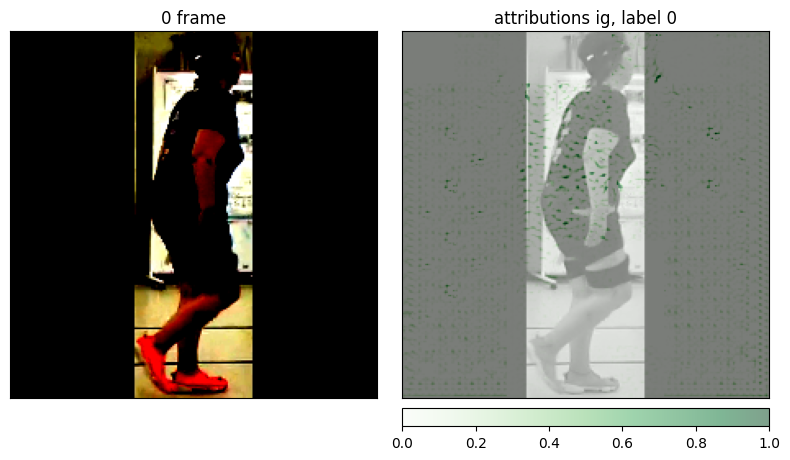

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


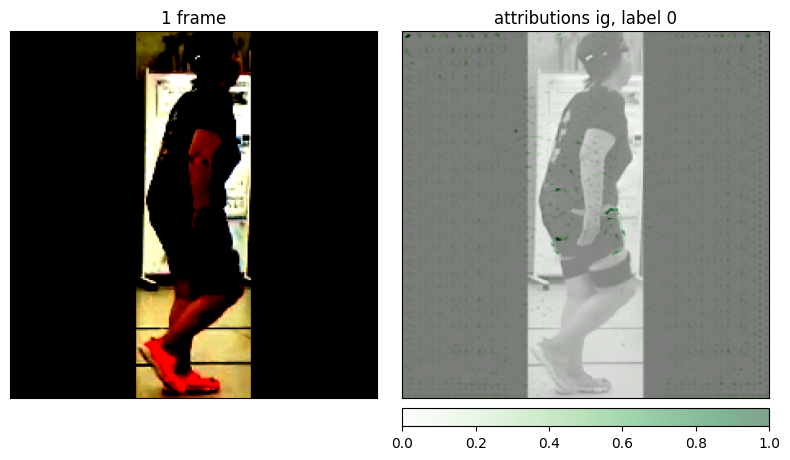

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


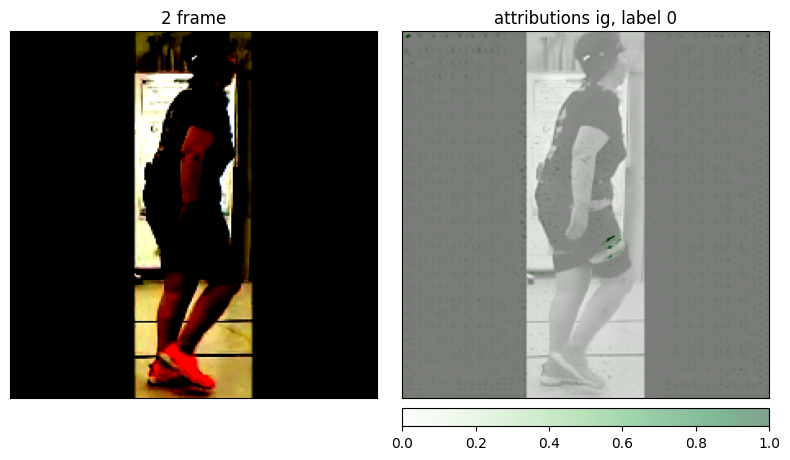

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


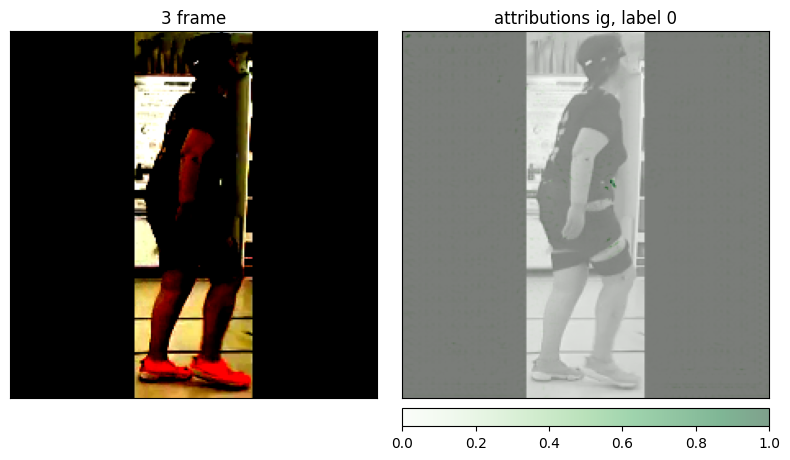

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


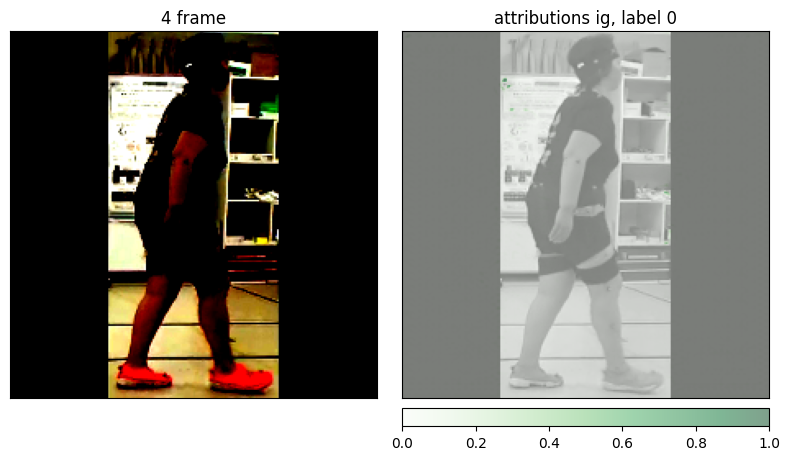

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


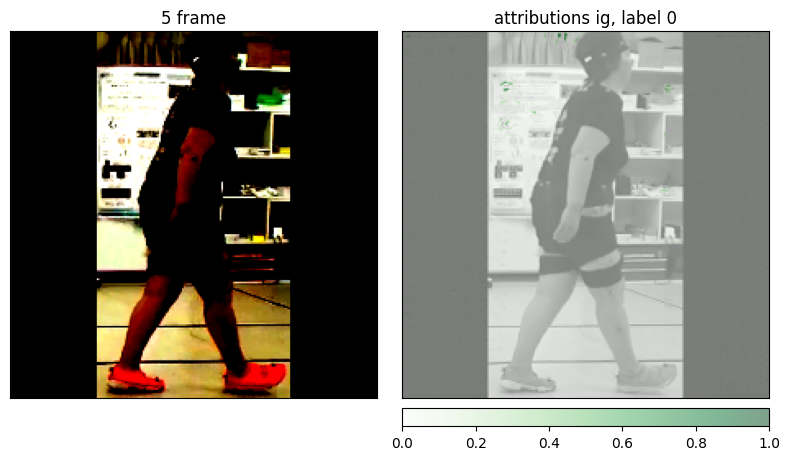

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


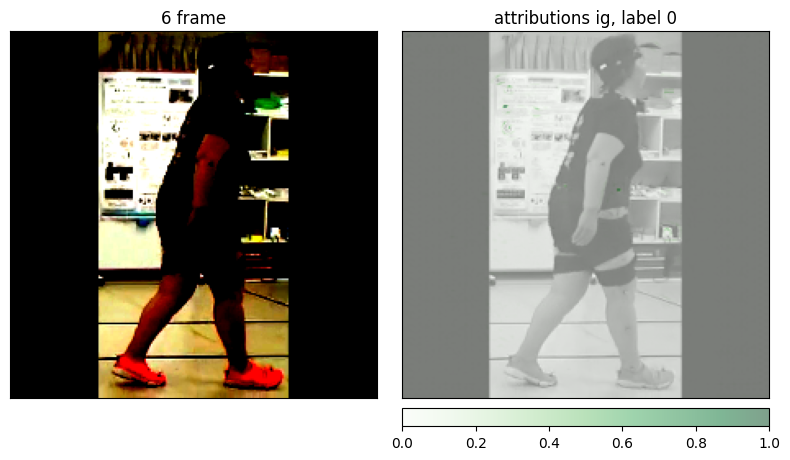

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


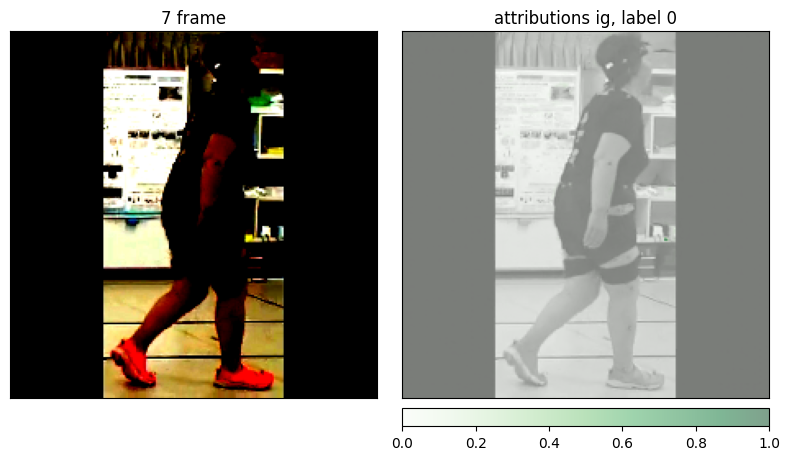

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


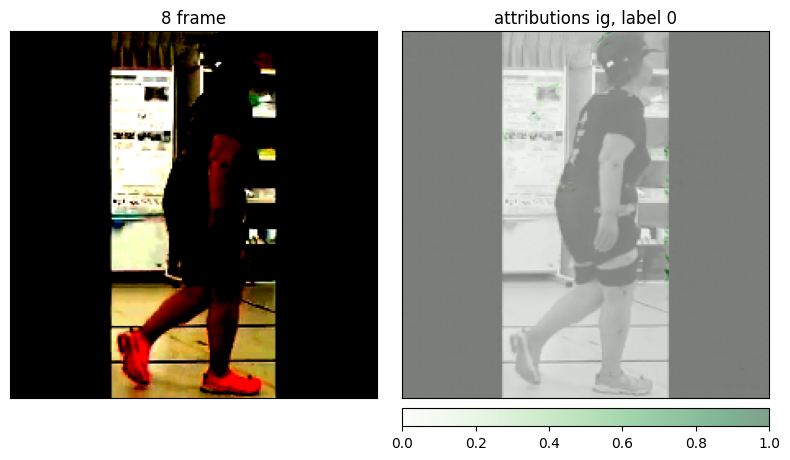

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


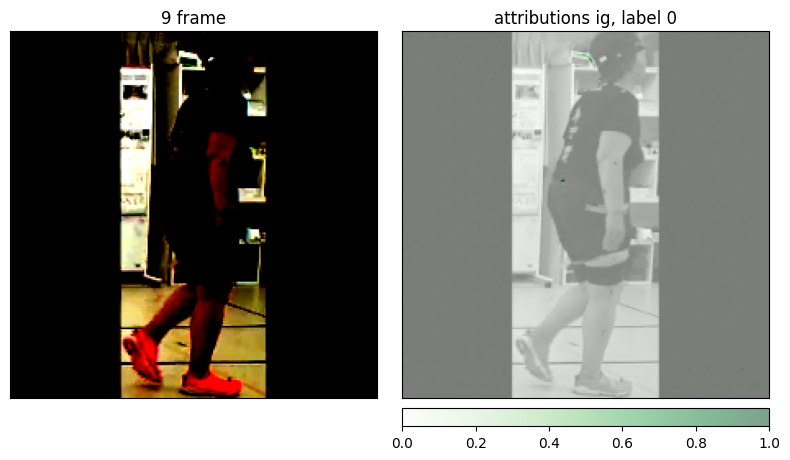

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


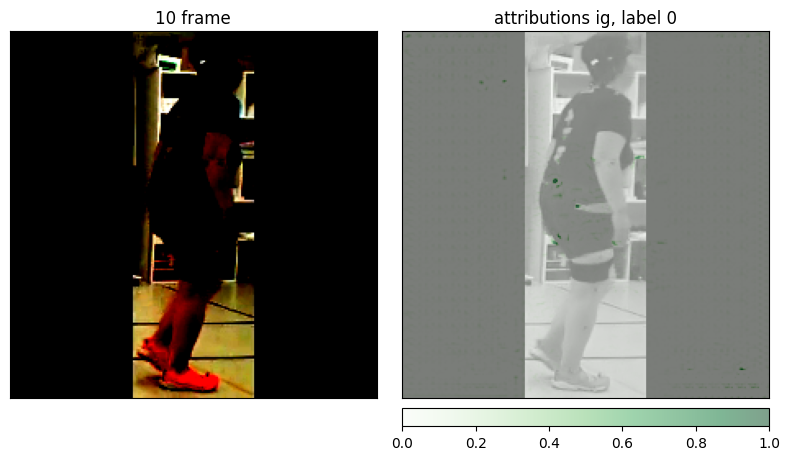

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


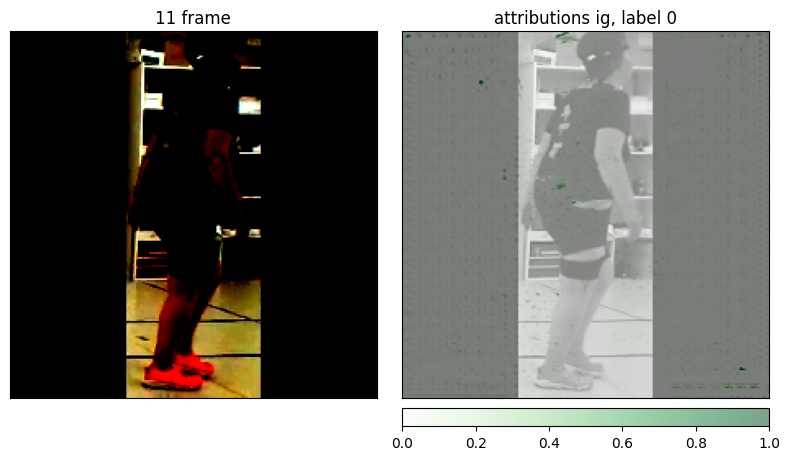

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


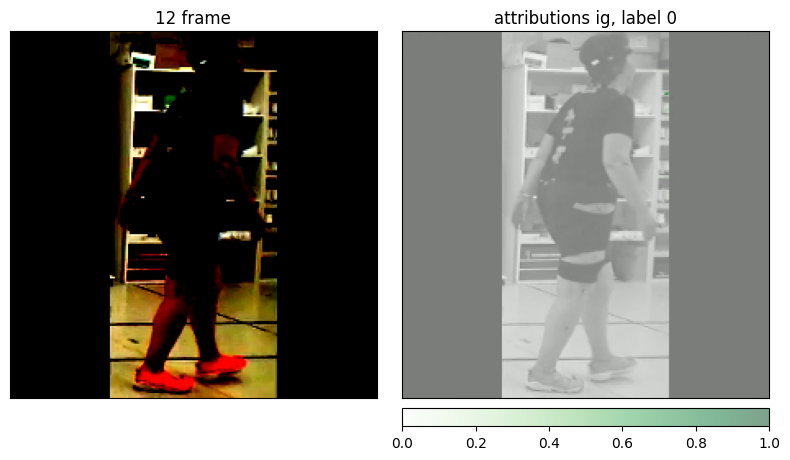

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


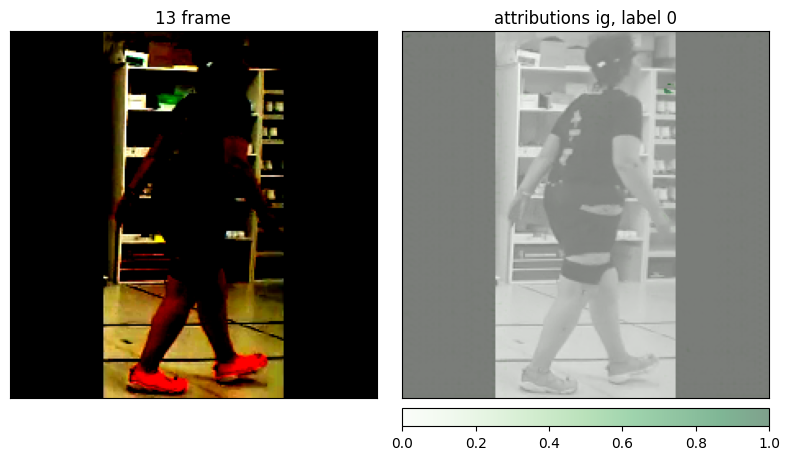

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


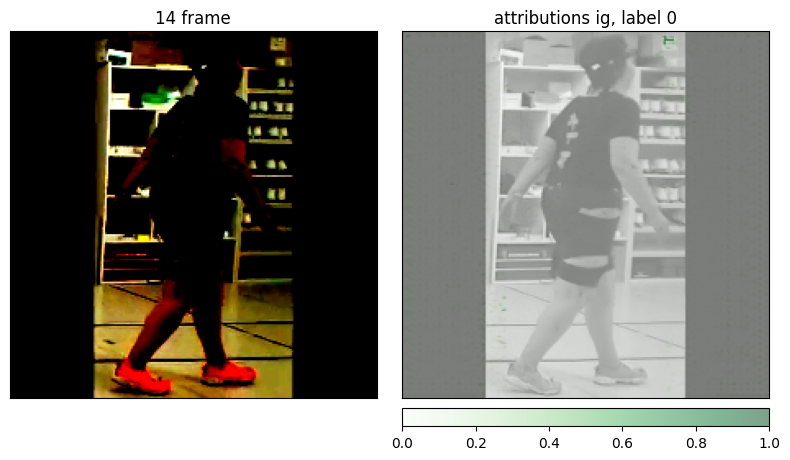

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


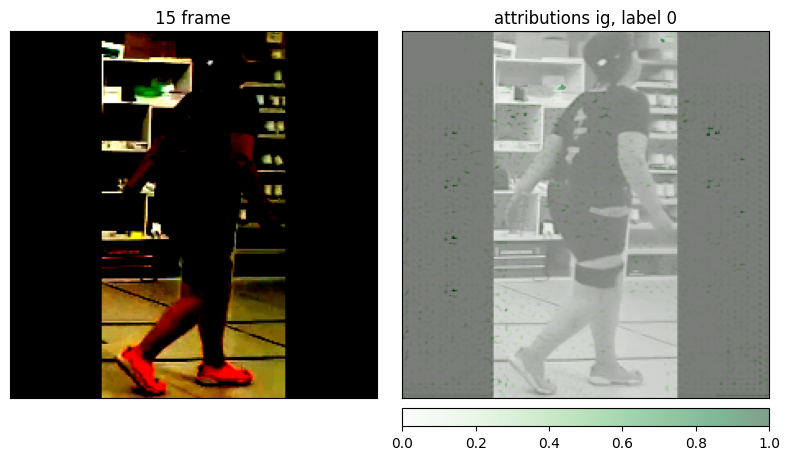

In [ ]:
guided_gc = GuidedGradCam(model.cuda(), target_layer)

input = video[0].unsqueeze(0).cuda()

attributions = guided_gc.attribute(input, target=0)

print('IG Attributions:', attributions.shape)

series_attr_show(attributions, input, flag=label[0])

In [ ]:
# deconvolution 
from captum.attr import Deconvolution

deconv = Deconvolution(model.cuda())

input = video[0].unsqueeze(0).cuda()

attributions = deconv.attribute(input, target=0)

In [ ]:
raw_img = video[0].squeeze().cpu().detach().numpy()
raw_img.shape

attributions_ig = attributions.squeeze().cpu().detach().numpy()
attributions_ig.shape

attributions_ig = attributions_ig.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
raw_img = raw_img.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
attributions_ig.shape, raw_img.shape

((224, 224, 3), (224, 224, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


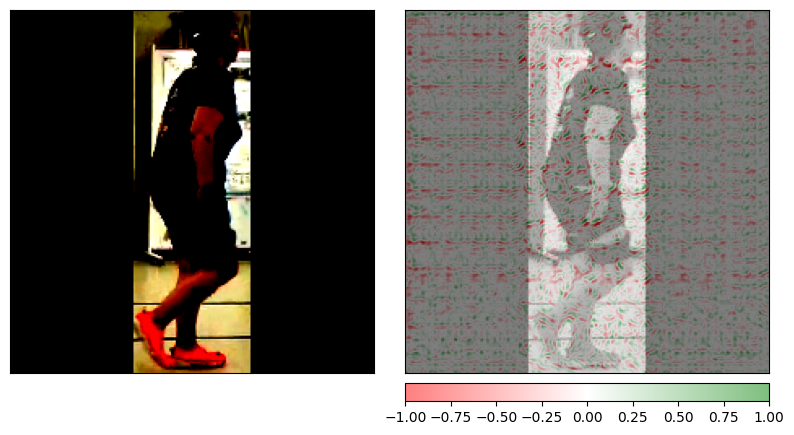

In [ ]:
figure, axis = viz.visualize_image_attr_multiple(attributions_ig, 
                             raw_img,
                             methods=['original_image', 'blended_heat_map'],
                             signs=['all', 'all'],
                             show_colorbar=True,
                             outlier_perc=1)

In [ ]:
# deep lift 
from captum.attr import DeepLift

dl = DeepLift(model.cuda())

input = video[0].unsqueeze(0).cuda()

attribution = dl.attribute(input, target=0)

In [ ]:
raw_img = video[0].squeeze().cpu().detach().numpy()
raw_img.shape

attributions_ig = attributions.squeeze().cpu().detach().numpy()
attributions_ig.shape

attributions_ig = attributions_ig.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
raw_img = raw_img.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
attributions_ig.shape, raw_img.shape

In [ ]:
figure, axis = viz.visualize_image_attr_multiple(attributions_ig, 
                             raw_img,
                             methods=['original_image', 'blended_heat_map'],
                             signs=['all', 'all'],
                             show_colorbar=True,
                             outlier_perc=1)

In [ ]:
# noise tunnel 
ig = IntegratedGradients(model.cuda())
noise_tunnel = NoiseTunnel(ig)

input = video[0].unsqueeze(0).cuda()

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=1, nt_type='smoothgrad_sq', target=0, nt_samples_batch_size=1)

In [ ]:
raw_img = video[0].squeeze().cpu().detach().numpy()
raw_img.shape

attributions_ig_nt = attributions_ig_nt.squeeze().cpu().detach().numpy()
attributions_ig_nt.shape

attributions_ig_nt = attributions_ig_nt.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
raw_img = raw_img.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
attributions_ig_nt.shape, raw_img.shape

In [ ]:
figure, axis = viz.visualize_image_attr_multiple(attributions_ig_nt, 
                             raw_img,
                             methods=['original_image', 'blended_heat_map'],
                             signs=['all', 'all'],
                             show_colorbar=True,
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


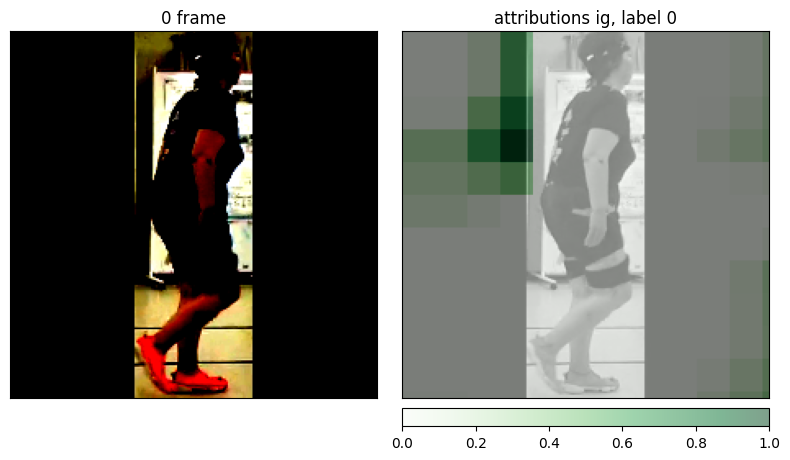

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


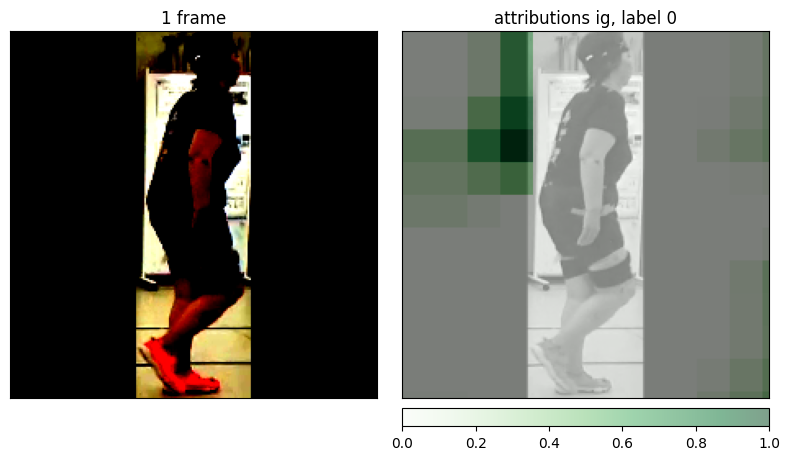

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


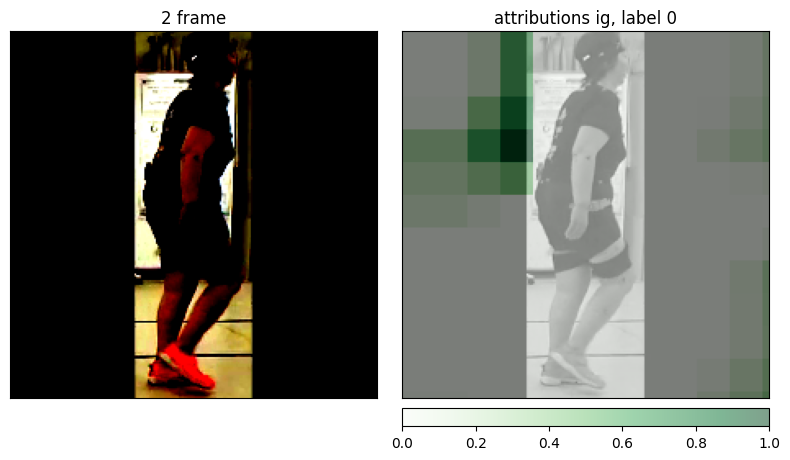

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


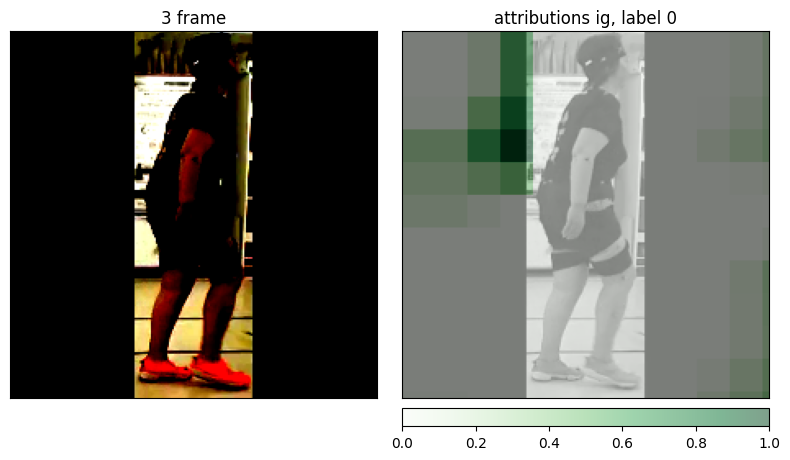

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


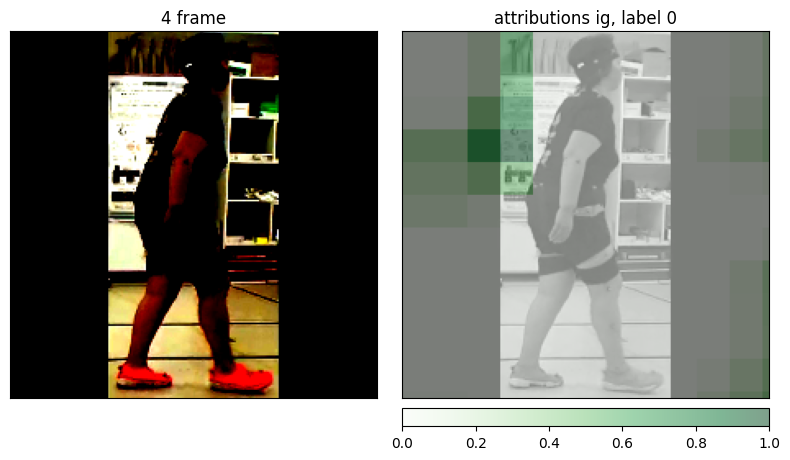

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


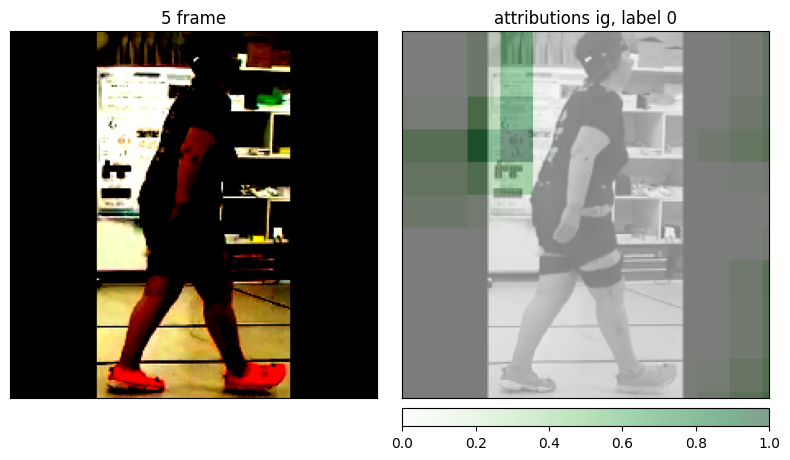

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


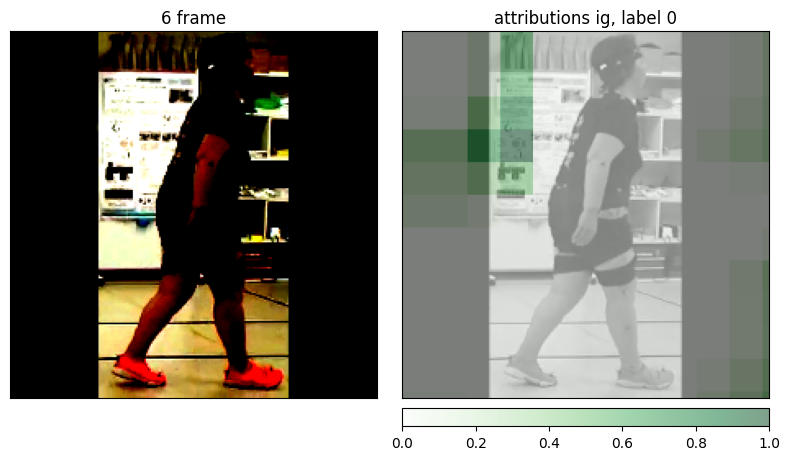

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


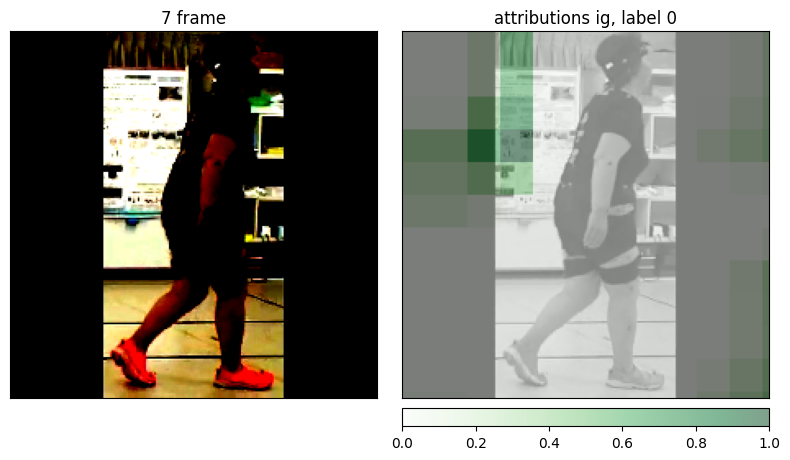

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


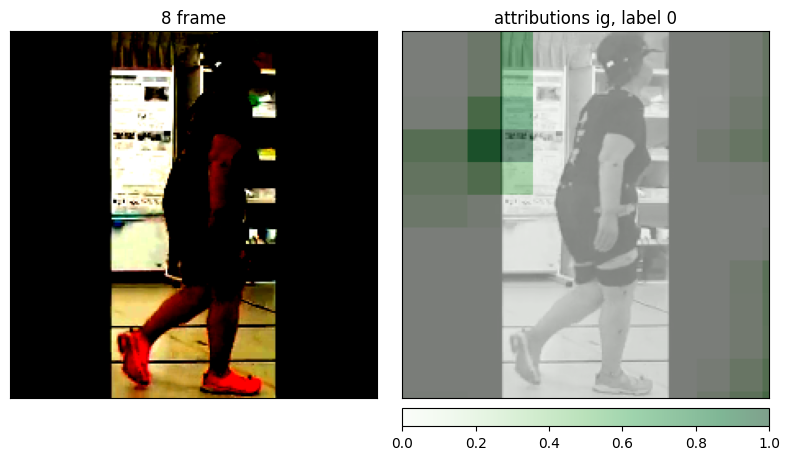

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


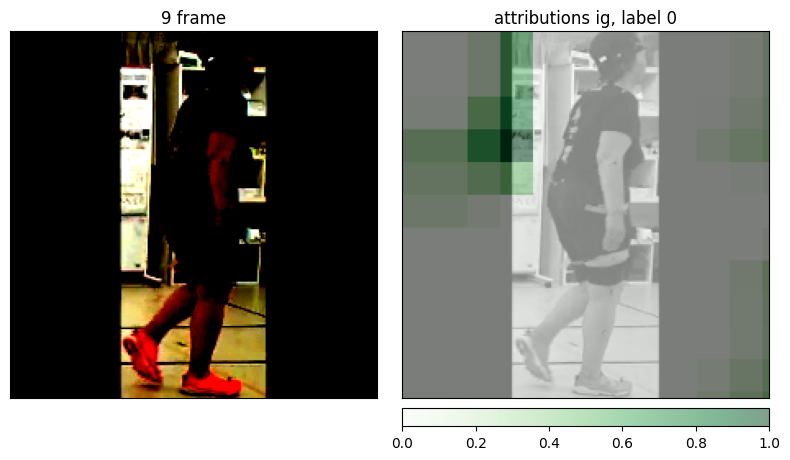

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


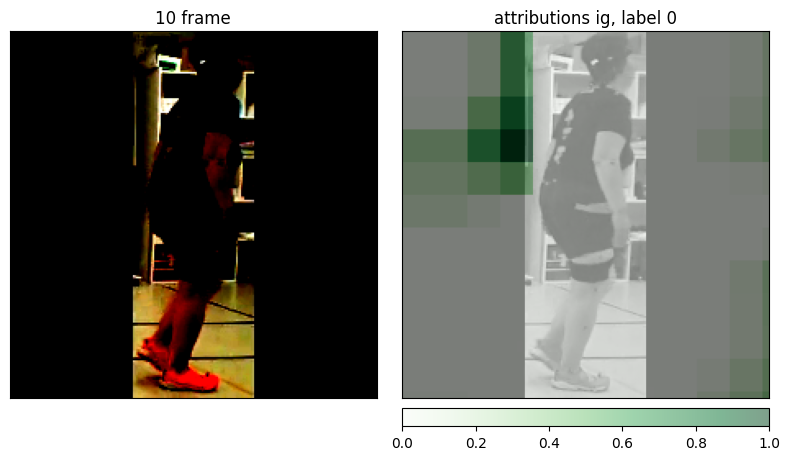

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


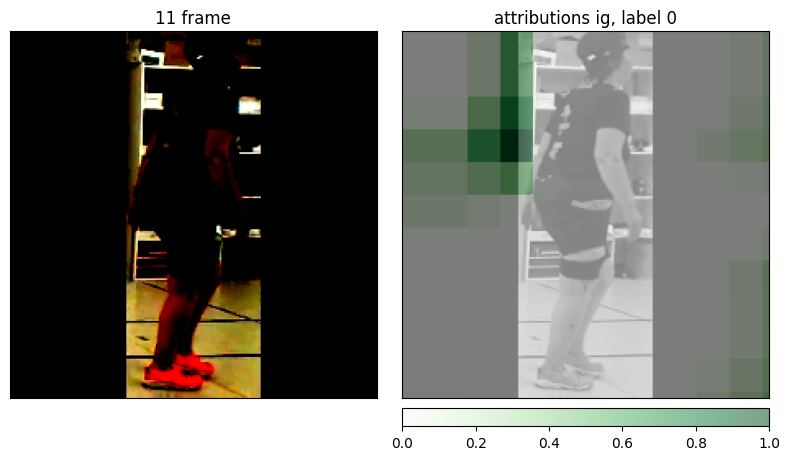

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


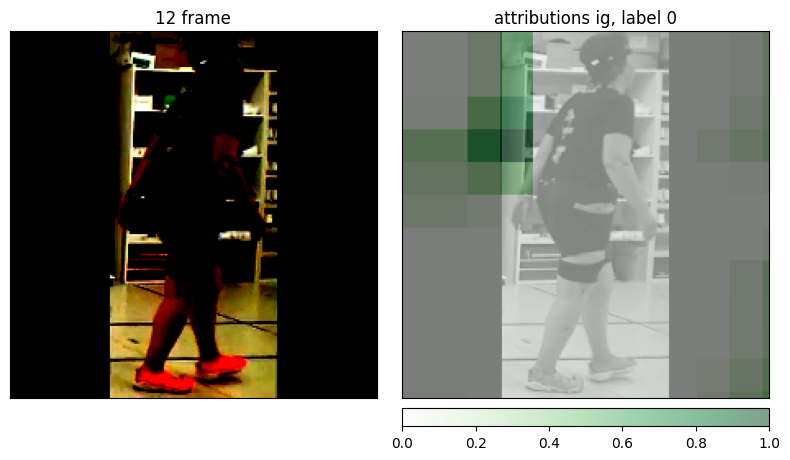

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


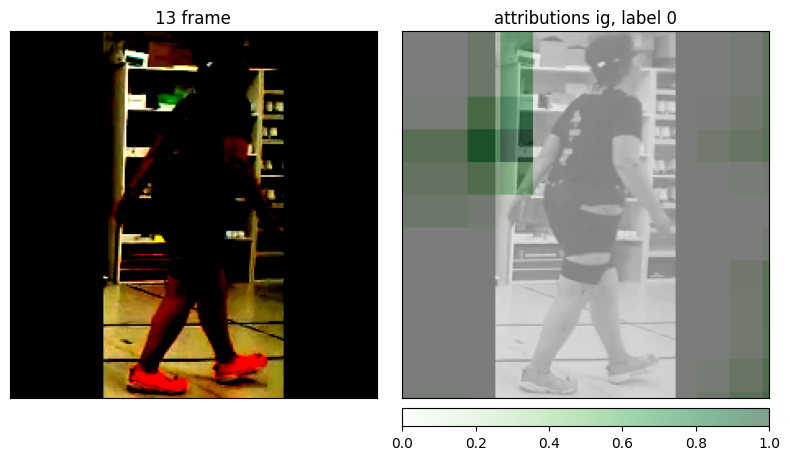

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


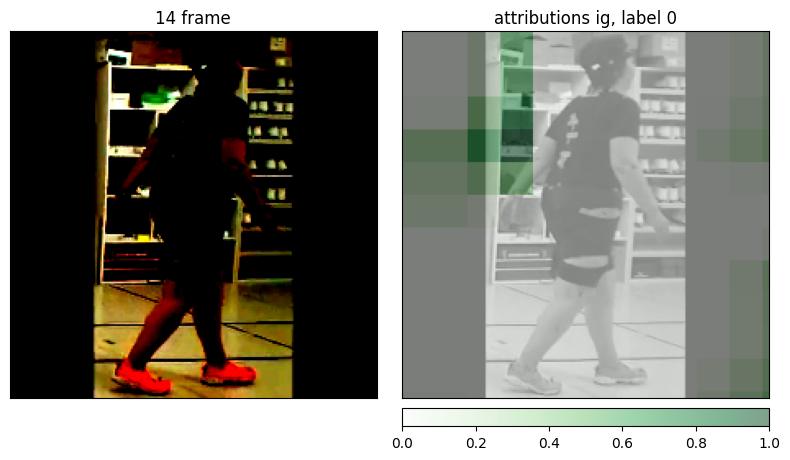

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


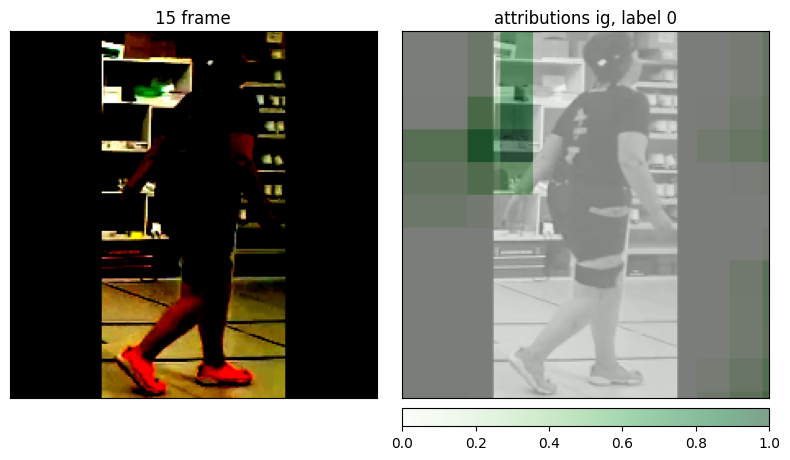

In [ ]:
# occlusion based attribution
from captum.attr import Occlusion

occlusion = Occlusion(model.cuda())

input = video[0].unsqueeze(0).cuda()

attributions_occ = occlusion.attribute(input,
                                       strides=(3, 16, 40, 40),
                                       target=0, sliding_window_shapes=(3, 16, 60, 60), baselines=0)

series_attr_show(attributions_occ, video[0], flag=label[0])